In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot
import seaborn as sbn
import seaborn as sbn
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [2]:
pd. set_option("display.max_columns", None) 

In [3]:
df = pd.read_csv('./android-fitness-and-medical-cleaned-data(no-duplicate).csv')

#### FEATURE ENGINNERING

**Rating Count Categorization**

1+, 5+, 10+, 50+, 100+, 500+, 1,000+, 5,000+, 10,000+, 50,000+, 100,000+, 500,000+, 1,000,000+, 5,000,000, 10,000,000+, 50,000,000+

In [4]:
def determine_if_app_is_free_or_not(price):
    if (price > 0):
        return 'PAID'
    return 'FREE'

In [5]:
def grade_app_with_rating(app_rating):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        return 'VERY GOOD'
    if (app_rating >=4.5):
        return 'EXCELLENT'

In [6]:
def grade_app_with_rating2(app_rating, rating_count):
    if ((app_rating >=0) and (app_rating <2.5)):
        return 'BAD'
    if ((app_rating >=2.5) and (app_rating <3.0)):
        return 'FAIR'
    if ((app_rating >=3.0) and (app_rating <4.0)):
        if rating_count < 50:
            return 'FAIR'
        return 'GOOD'
    if ((app_rating >=4.0) and (app_rating <4.5)):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD' 
        else:
            return 'VERY GOOD'
    if (app_rating >=4.5):
        if rating_count < 50:
            return 'FAIR'
        elif rating_count >=50 and rating_count <100:
            return 'GOOD'
        elif rating_count >=100 and rating_count < 500:
            return 'VERY GOOD'
        else:
            return 'EXCELLENT'

In [7]:
def create_rating_count_range(rating_count):
    if (rating_count >=1 and rating_count<5):
        return '1+'
    if (rating_count >=5 and rating_count<10):
        return '5+'
    if (rating_count >=10 and rating_count<50):
        return '10+'
    if (rating_count >=50 and rating_count<100):
        return '50+'
    if (rating_count >=100 and rating_count<500):
        return '100+'
    if (rating_count >=500 and rating_count<1000):
        return '500+'
    if (rating_count >=1000 and rating_count<5000):
        return '1,000+'
    if (rating_count >=5000 and rating_count<10000):
        return '5,000+'
    if (rating_count >=10000 and rating_count<50000):
        return '10,000+'
    if (rating_count >=50000 and rating_count<100000):
        return '50,000+'
    if (rating_count >=100000 and rating_count<500000):
        return '100,000+'
    if (rating_count >=500000 and rating_count<1000000):
        return '500,000+'
    if (rating_count >=1000000 and rating_count<5000000):
        return '1,000,000+'
    if (rating_count >=5000000 and rating_count<10000000):
        return '5,000,000+'
    if (rating_count >=10000000 and rating_count<50000000):
        return '10,000,000+'
    if (rating_count >=50000000 and rating_count<100000000):
        return '50,000,000+'
    return 0

In [8]:
def is_app_updated_in_2022(last_updated_date, released_date, version):
    if (version == '1.0.0'):
        return False
    if (last_updated_date == released_date):
        return False
    if '2022' in last_updated_date:
        return True
    return False

In [9]:
def is_app_ever_updated(last_updated_date, released_date, version):
    if (version == '1.0.0'):
        return False
    if (last_updated_date == released_date):
        return False
    return True

In [10]:
def is_app_version_device_dependent(version):
    return version == 'Varies with device'

In [11]:
def is_app_available_in_multiple_countries(count):
    return count > 1

In [12]:
def create_price_category(price):
    if (price >0.0 and price<1.0):
        return '0+'
    if (price >=1 and price<5):
        return '1+'
    if (price >=5 and price<10):
        return '5+'
    if (price >=10 and price<50):
        return '10+'
    if (price >=50 and price<100):
        return '50+'
    if (price >=100 and price<500):
        return '100+'
    if (price >=500 and price<1000):
        return '500+'
    return 0

In [13]:
def perform_feature_engineering(df):
    df['Download Type'] = df['Price'].apply(determine_if_app_is_free_or_not)
    df['is_available_in_multiple_countries'] = df['Country Count'].apply(is_app_available_in_multiple_countries)
    df['is_version_app_dependent'] = df['Version'].apply(is_app_version_device_dependent)
    df['Rating Count Range'] = df['Rating Count'].apply(create_rating_count_range)
    df['Price Category'] = df['Price'].apply(create_price_category)
#     df['App Grade'] = df['Average Rating'].apply(grade_app_with_rating)
    for index in df.index:
        link = df.at[index, 'App Link']
        last_updated_date = df.at[index, 'Last Updated']
        released_date = df.at[index, 'Released Date']
        version = df.at[index, 'Version']
        rating_count = df.at[index, 'Rating Count']
        average_rating = df.at[index, 'Average Rating']
        df.at[index, 'is_updated_this_year'] = is_app_updated_in_2022(last_updated_date, released_date, version)
        df.at[index, 'is_app_ever_updated'] = is_app_ever_updated(last_updated_date, released_date, version)
        df.at[index, 'App Grade'] = grade_app_with_rating2(average_rating, rating_count)

In [14]:
perform_feature_engineering(df)

#### VISUALIZATION

In [15]:
def draw_histogram(data, x_axis_title, height=5, aspect=1.6):
    sbn.displot(data, color = 'darkblue', kind='hist', height=5, aspect=1.6)
    pyplot.xlabel(x_axis_title)
    pyplot.ylabel('Density')

def draw_count_plot(data, x_column, x_label, y_label, fig_size=(8,6), order=None, hue=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue )
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.show()

def set_plot_labels(x_label, y_label, font_size):
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=font_size)

In [16]:
def draw_count_plot_with_annot(data, x_column, x_label, y_label, fig_size=(8,6),annotCount=False, order=None, 
                               hue=None, palette=None):
    sbn.set(rc = {'figure.figsize':fig_size})
    sbndataplot = sbn.countplot(data=data, x=x_column, order=order, color='#1C8BAD', hue=hue, palette=palette)
    for p in sbndataplot.patches:
        if annotCount == True:
            height = p.get_height()
            if (pd.isna(height) == True):
                height = 0
            else:
                height = int(height)
            sbndataplot.annotate(height, 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        else:
            sbndataplot.annotate(format(p.get_height()/len(data)*100, '.2f')+'%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    pyplot.xlabel(x_label)
    pyplot.ylabel(y_label)
    pyplot.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='large')
    pyplot.tight_layout(rect=(0, 0, 1, 1.4))
    pyplot.show()

In [17]:
rating_count_range_order = [0, '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', '5,000+', '10,000+', '50,000+', 
                            '100,000+', '500,000+', '1,000,000+', '5,000,000+']
price_range_order = [0, '0+', '1+', '5+', '10+', '50+', '100+', '500+']
app_grade_order = ['BAD', 'FAIR', 'GOOD', 'VERY GOOD', 'EXCELLENT']

#### Price influence

In [18]:
df['Price'].max(), df['Price'].min()

(109.99, 0.0)

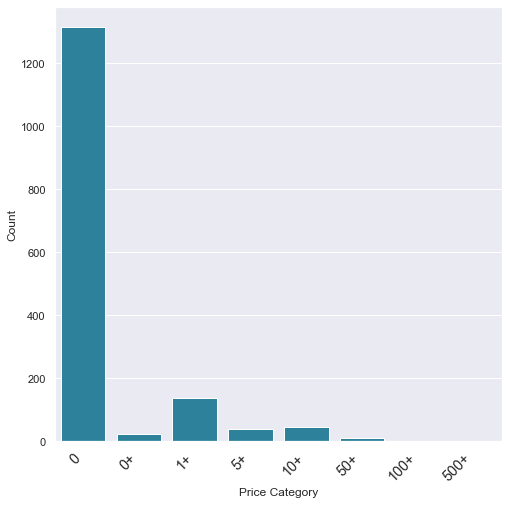

In [19]:
draw_count_plot(df, 'Price Category', 'Price Category', 'Count', fig_size=(8,8), 
               order=price_range_order)

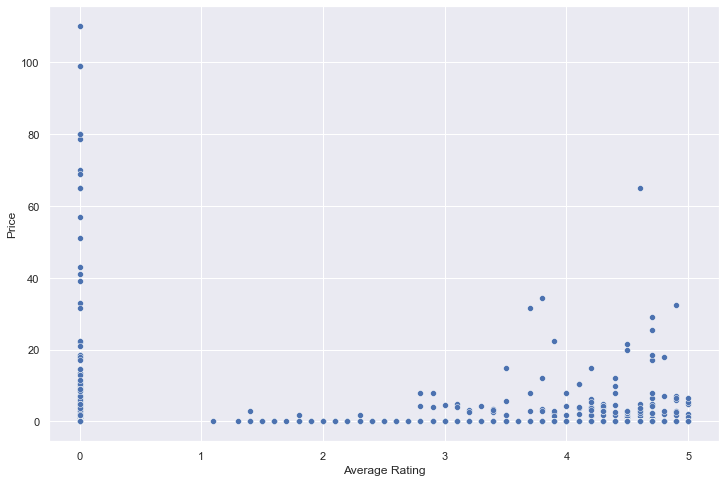

In [20]:
sbn.scatterplot(data=df, y='Price', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

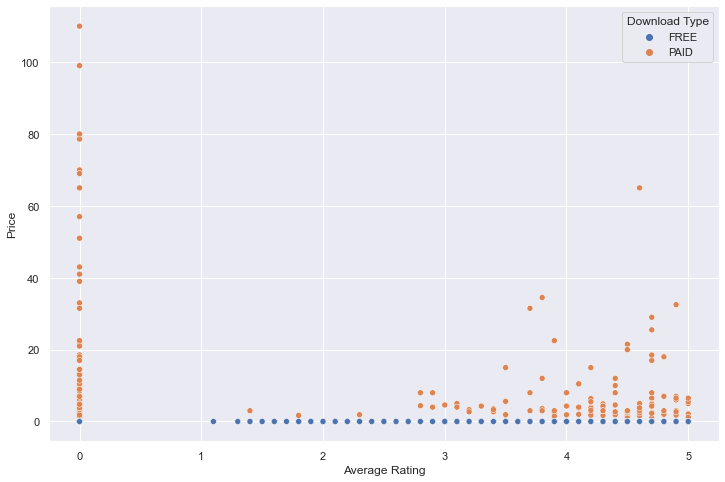

In [21]:
sbn.scatterplot(data=df, y='Price', x='Average Rating', hue='Download Type', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

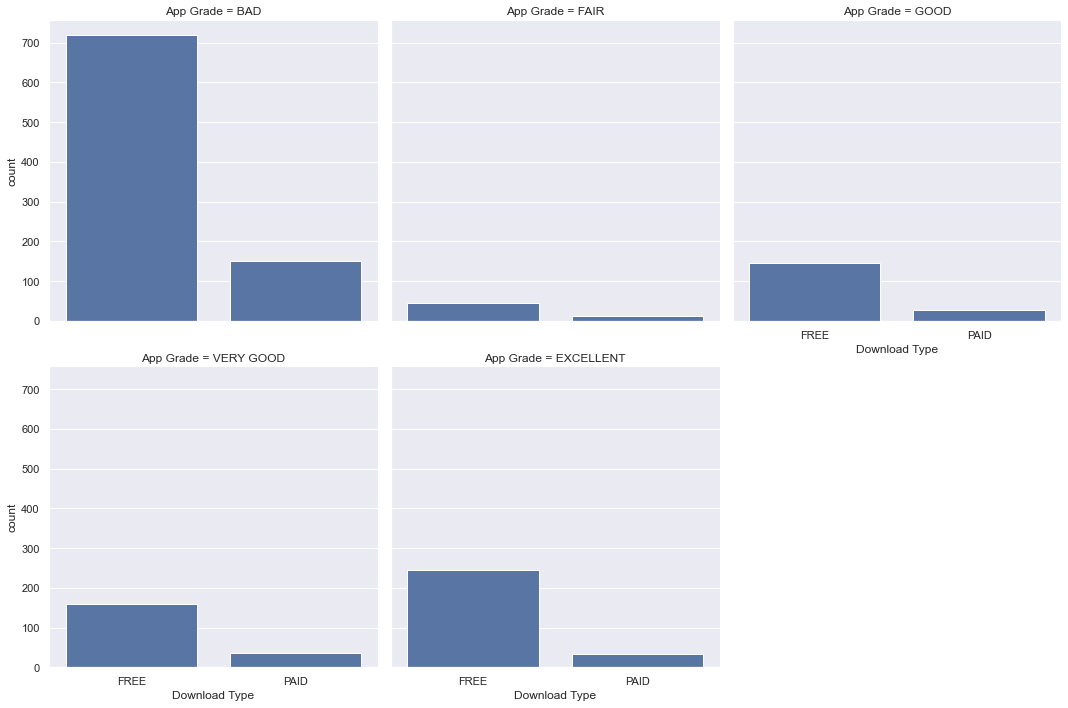

In [22]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Grade", col_wrap=3, height=5, aspect=1.0,
                                        col_order=app_grade_order)
eng_supp_app_grade_plot.map(sbn.countplot, "Download Type", order=['FREE', 'PAID'])

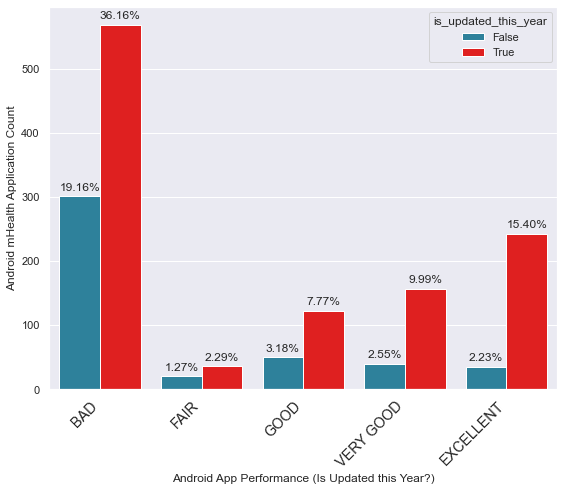

In [23]:
draw_count_plot_with_annot(df, 'App Grade', 'Android App Performance (Is Updated this Year?)',
                           'Android mHealth Application Count',hue= 'is_updated_this_year', fig_size=(8,5),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

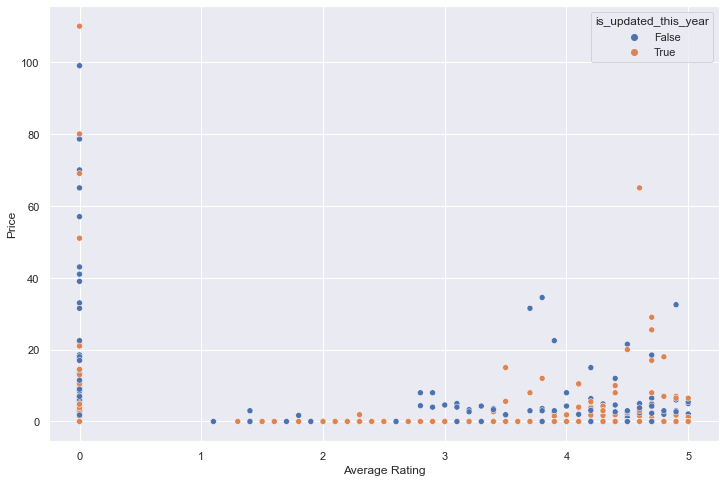

In [24]:
sbn.scatterplot(data=df, x='Average Rating', y='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


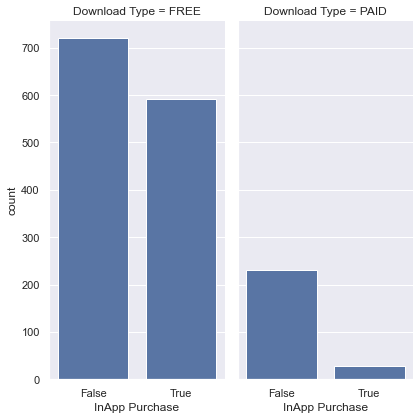

In [25]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="Download Type", col_wrap=2, height=6, aspect=0.5)
eng_supp_app_grade_plot.map(sbn.countplot, "InApp Purchase")

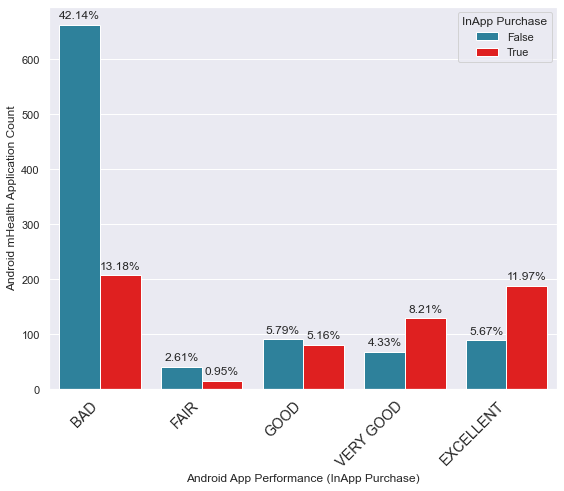

In [26]:
draw_count_plot_with_annot(df, 'App Grade', 'Android App Performance (InApp Purchase)',
                           'Android mHealth Application Count',hue= 'InApp Purchase', fig_size=(8,5),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

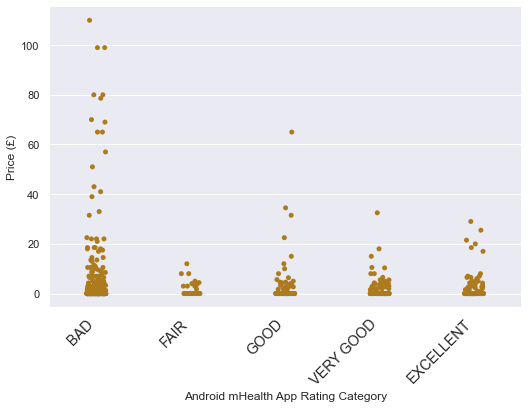

In [27]:
sbn.catplot(data=df, x='App Grade', y='Price',
            height=5, aspect=1.5, color="#AD7B1D", order=app_grade_order)
set_plot_labels('Android mHealth App Rating Category', 'Price (£)', 'large')

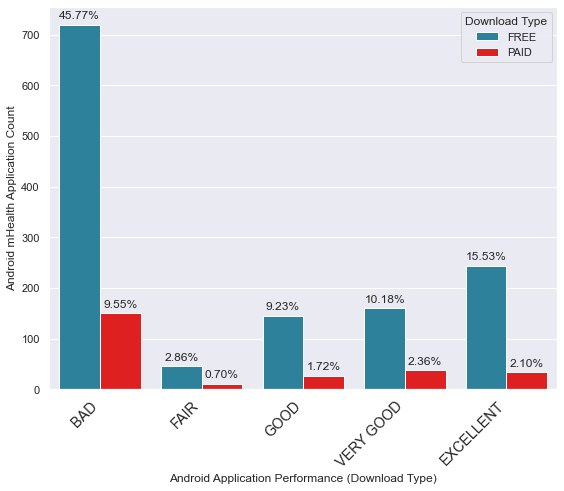

In [28]:
draw_count_plot_with_annot(df, 'App Grade', 'Android Application Performance (Download Type)',
                           'Android mHealth Application Count',hue= 'Download Type', fig_size=(8,5), 
                           order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

#### Application Rating effect on the app?

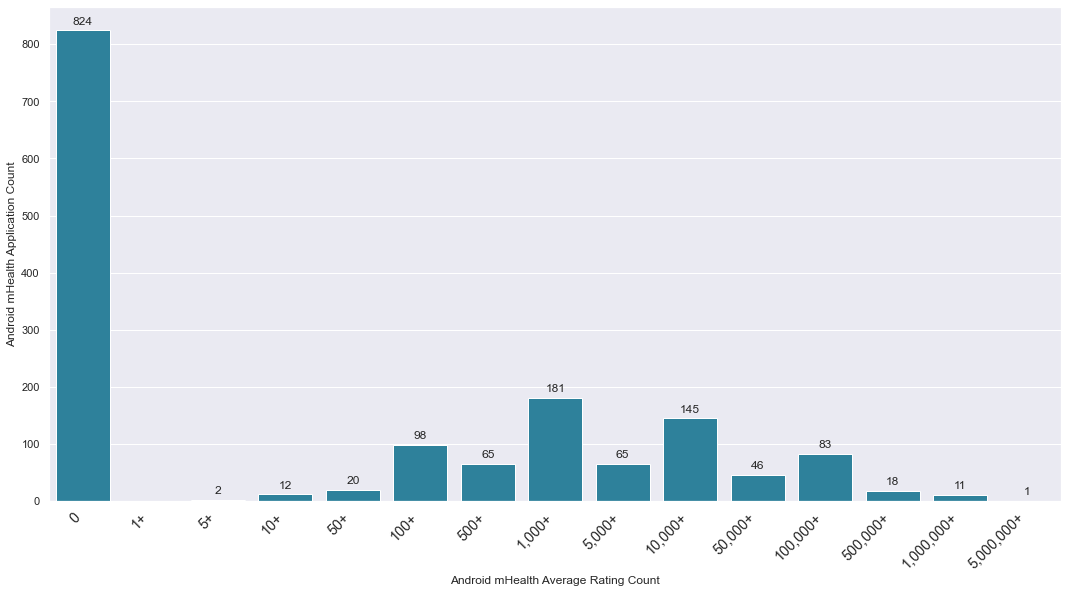

In [29]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'Android mHealth Average Rating Count', 
                           'Android mHealth Application Count',fig_size=(15,6), annotCount=True,
                           order=rating_count_range_order)

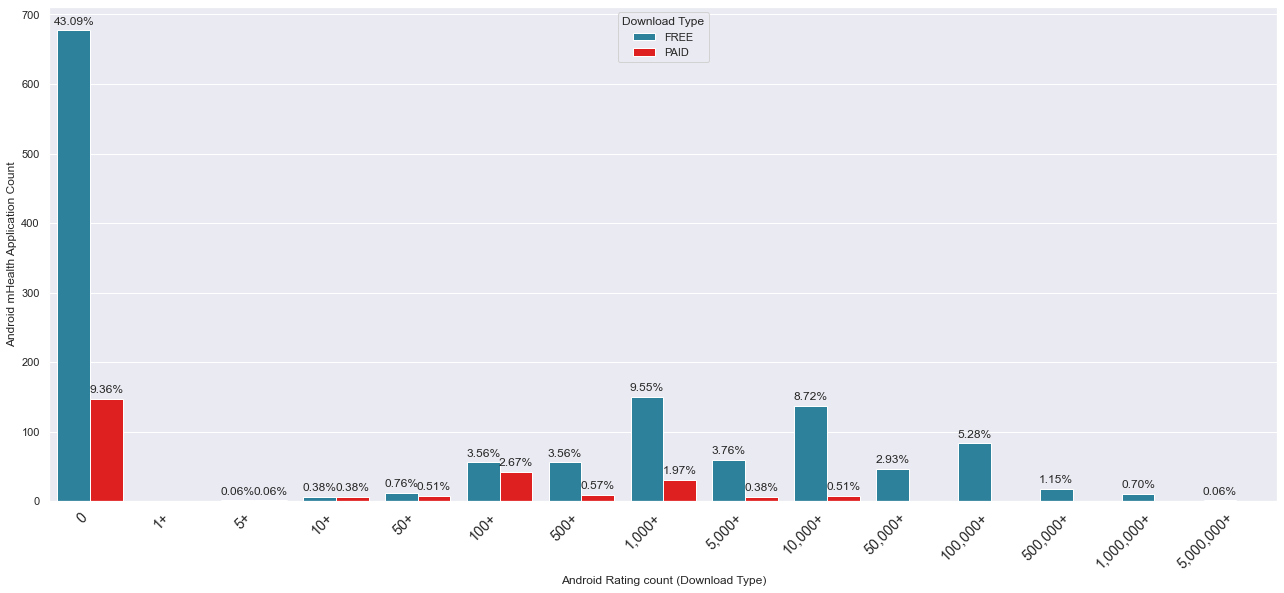

In [30]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'Android Rating count (Download Type)',
                           'Android mHealth Application Count',hue= 'Download Type', fig_size=(18,6), 
                           
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

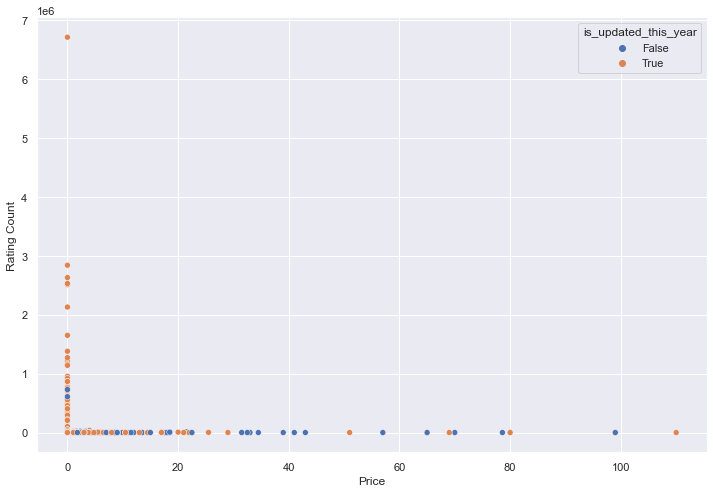

In [31]:
sbn.scatterplot(data=df, y='Rating Count', x='Price', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

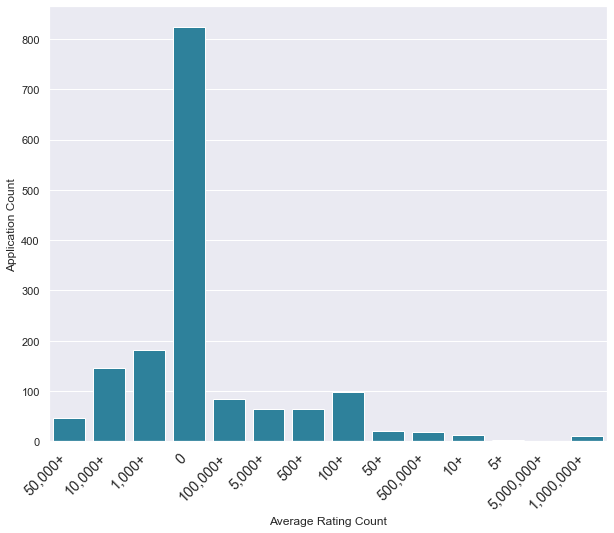

In [32]:
draw_count_plot(df, 'Rating Count Range', 'Average Rating Count', 'Application Count', fig_size=(10,8))

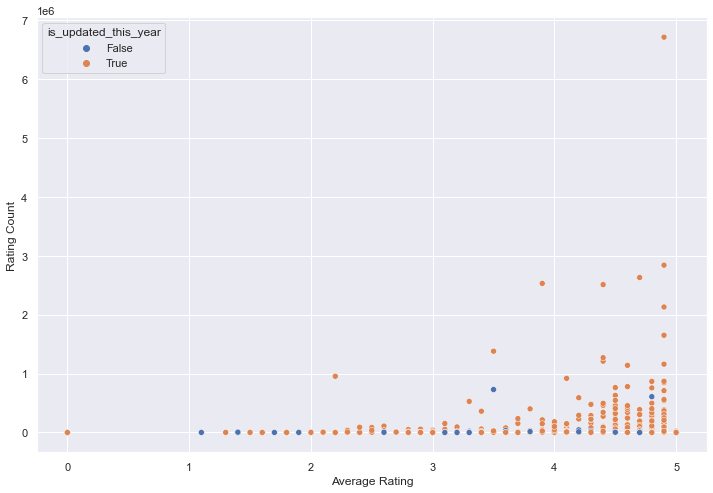

In [33]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating', hue='is_updated_this_year', legend='full')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)

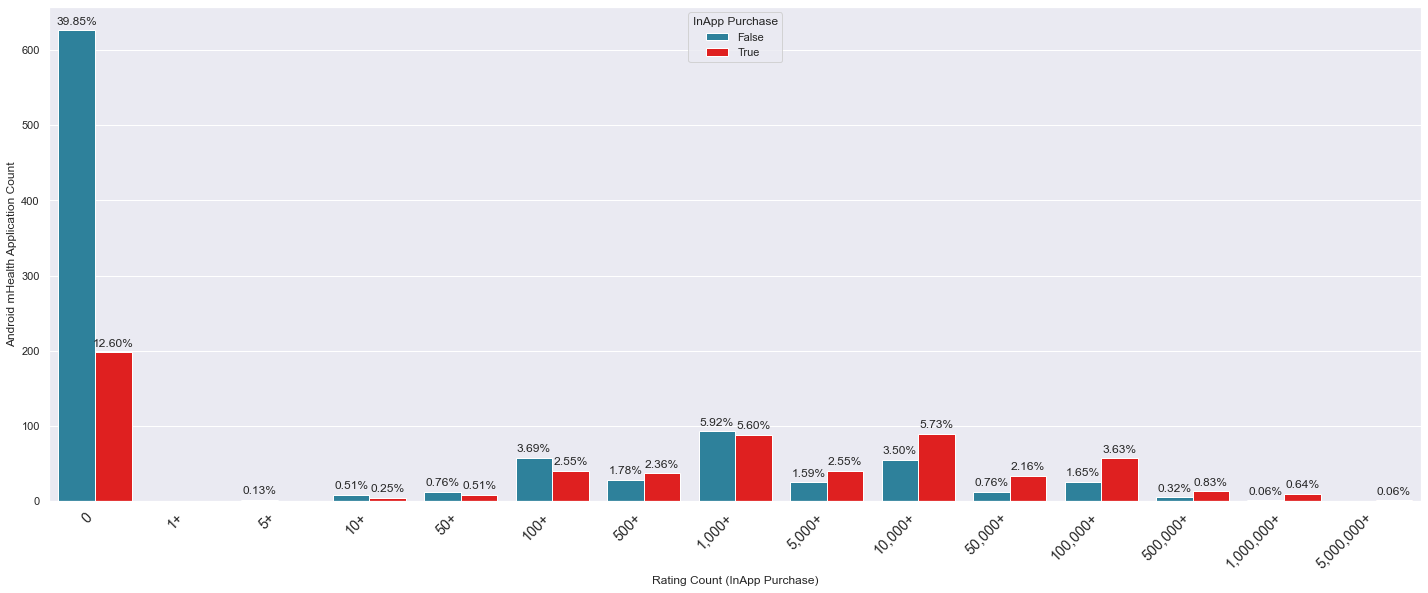

In [34]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'Rating Count (InApp Purchase)',
                           'Android mHealth Application Count',hue= 'InApp Purchase', fig_size=(20,6), 
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

#### Application Type 

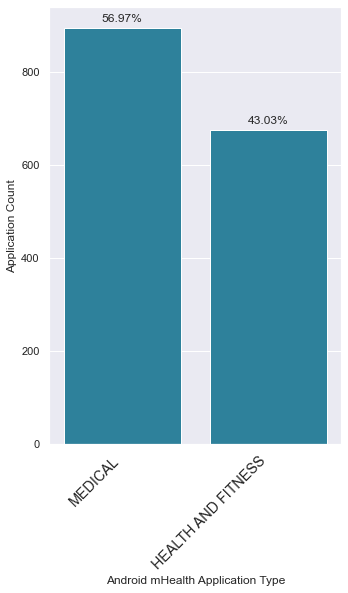

In [35]:
draw_count_plot_with_annot(df, 'App Type', 'Android mHealth Application Type', 
                           'Application Count', fig_size=(5,6), annotCount=False)

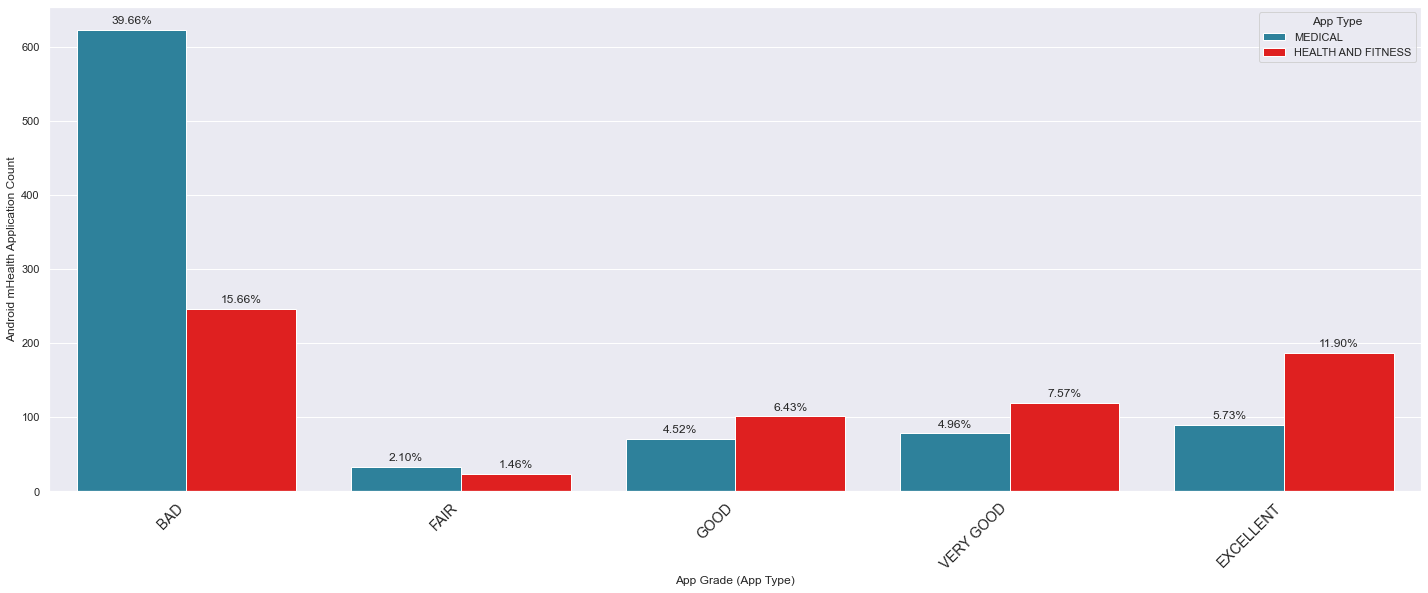

In [36]:
draw_count_plot_with_annot(df, 'App Grade', 'App Grade (App Type)',
                           'Android mHealth Application Count',hue= 'App Type', fig_size=(20,6), 
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

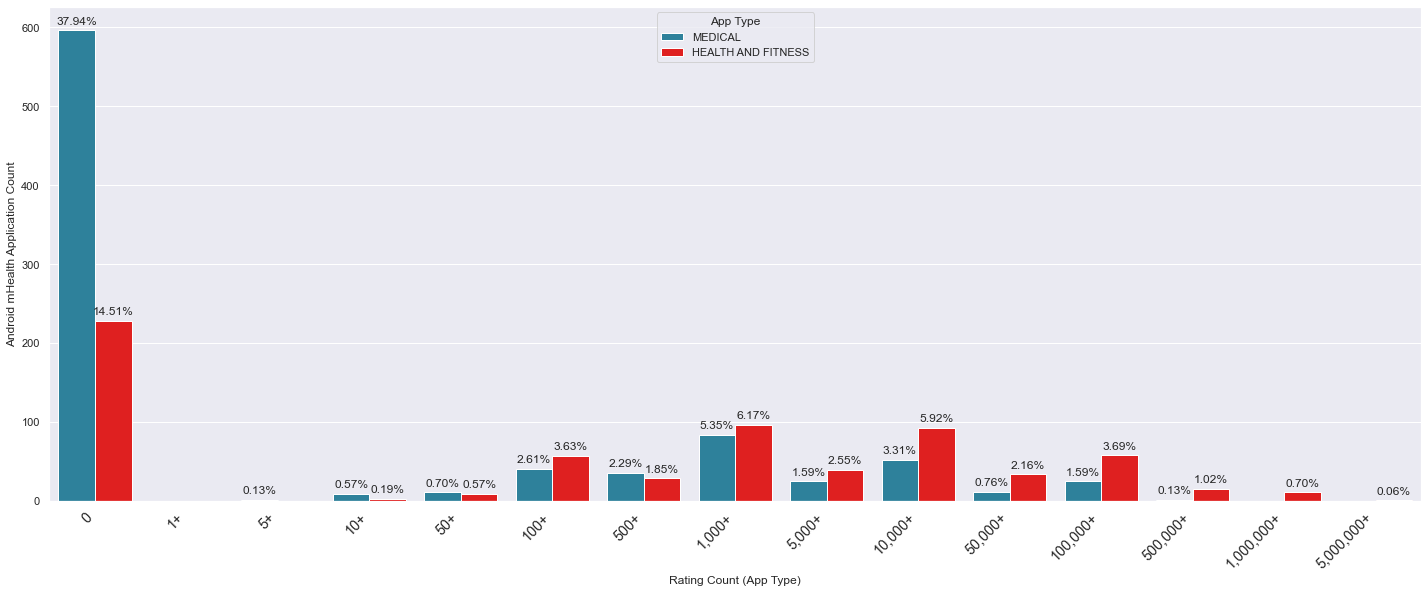

In [37]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'Rating Count (App Type)',
                           'Android mHealth Application Count',hue= 'App Type', fig_size=(20,6), 
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

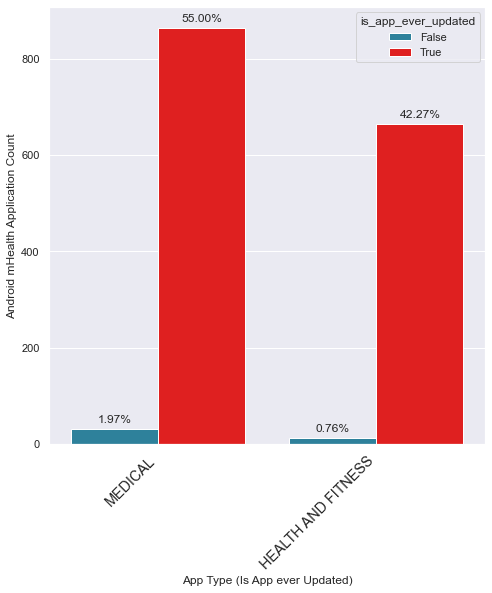

In [38]:
draw_count_plot_with_annot(df, 'App Type', 'App Type (Is App ever Updated)',
                           'Android mHealth Application Count',hue= 'is_app_ever_updated', fig_size=(7,6), 
     order=['MEDICAL', 'HEALTH AND FITNESS'], annotCount=False, palette=['#1C8BAD', 'red'])

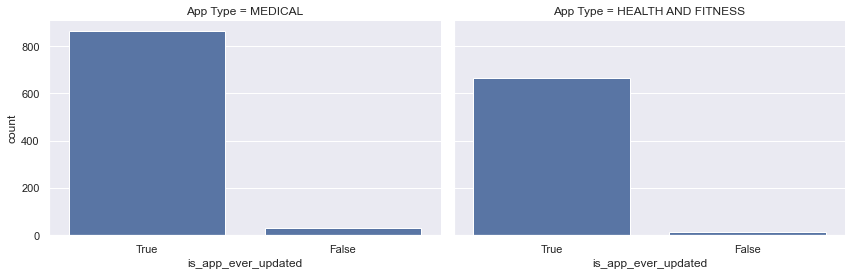

In [39]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_app_ever_updated", order=[True, False])

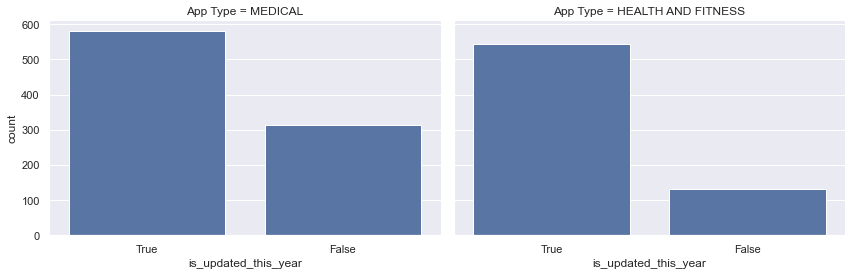

In [40]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_updated_this_year", order=[True, False])

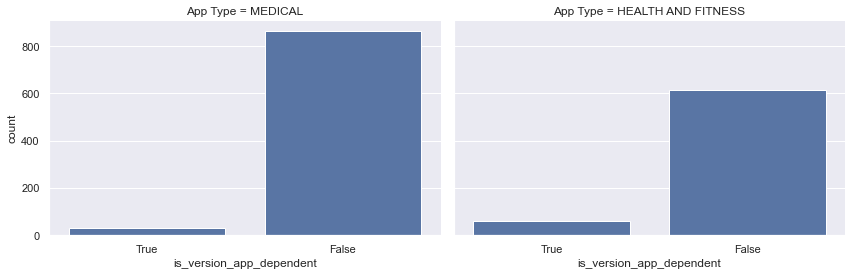

In [41]:
eng_supp_app_grade_plot = sbn.FacetGrid(df, col="App Type", col_wrap=2, height=4, aspect=1.5)
eng_supp_app_grade_plot.map(sbn.countplot, "is_version_app_dependent", order=[True, False])

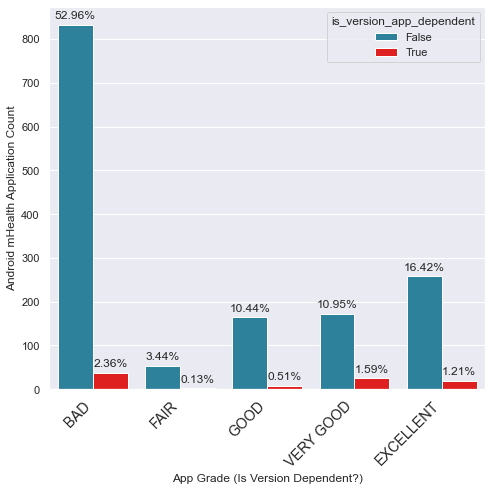

In [42]:
draw_count_plot_with_annot(df, 'App Grade', 'App Grade (Is Version Dependent?)',
                           'Android mHealth Application Count',hue= 'is_version_app_dependent', fig_size=(7,5), 
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

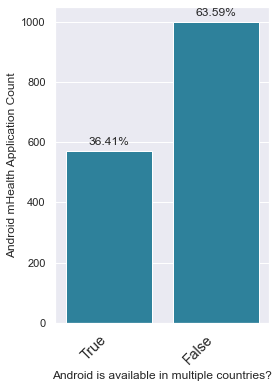

In [43]:
draw_count_plot_with_annot(df, 'is_available_in_multiple_countries', 'Android is available in multiple countries?',
                           'Android mHealth Application Count',fig_size=(4,4),
                           annotCount=False, order=[True, False])

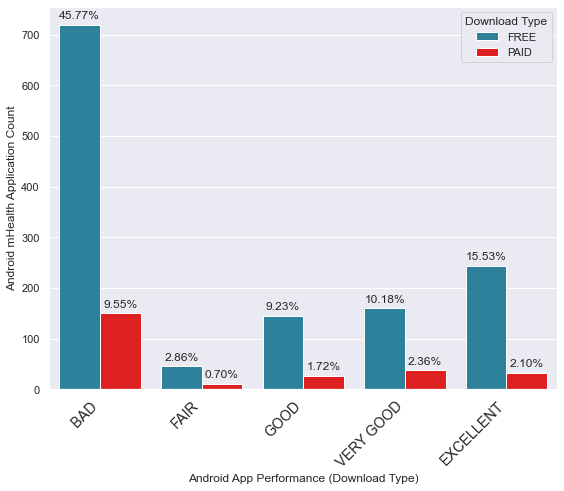

In [44]:
draw_count_plot_with_annot(df, 'App Grade', 'Android App Performance (Download Type)',
                           'Android mHealth Application Count',hue= 'Download Type', fig_size=(8,5),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

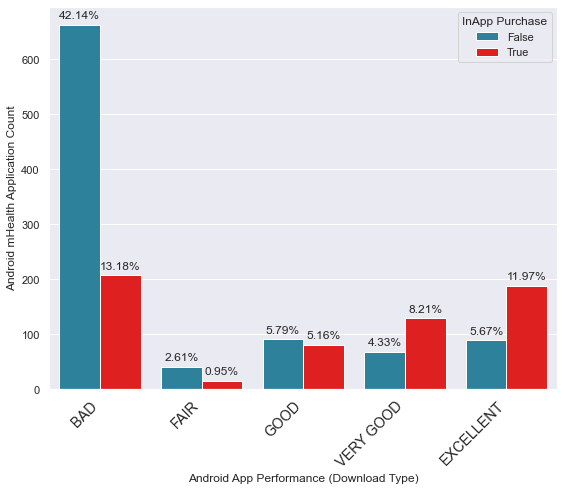

In [45]:
draw_count_plot_with_annot(df, 'App Grade', 'Android App Performance (Download Type)',
                           'Android mHealth Application Count',hue= 'InApp Purchase', fig_size=(8,5),
                           order=app_grade_order,
                           annotCount=False, palette=['#1C8BAD', 'red'])

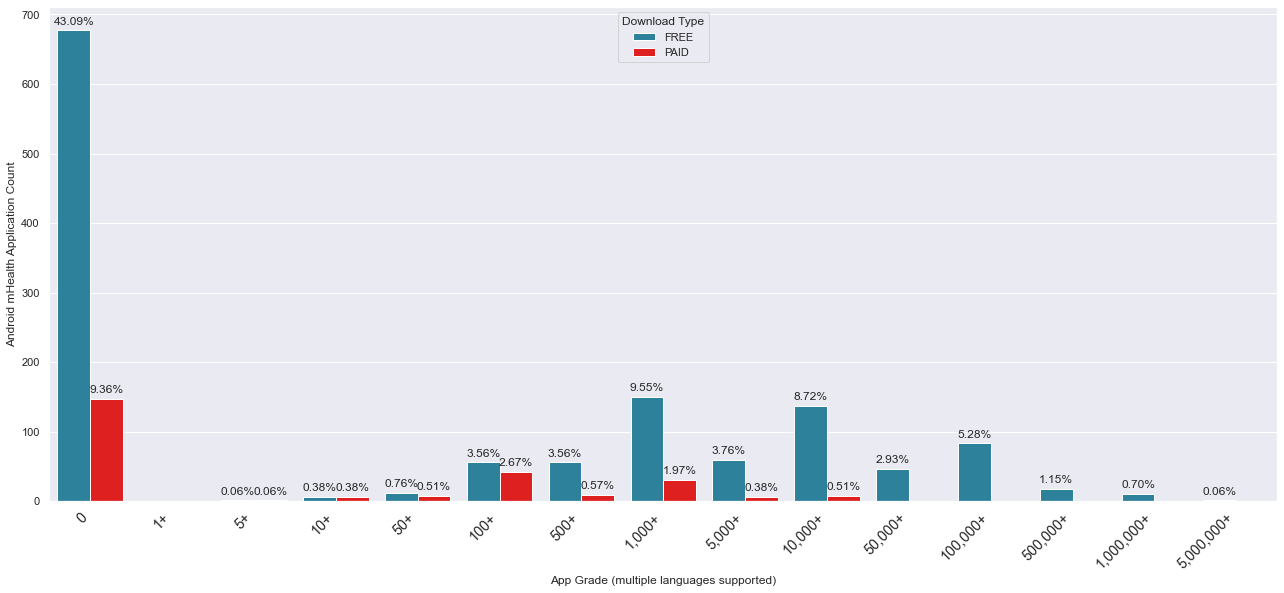

In [46]:
draw_count_plot_with_annot(df, 'Rating Count Range', 'App Grade (multiple languages supported)',
                           'Android mHealth Application Count',hue= 'Download Type', fig_size=(18,6), 
                           
     order=rating_count_range_order, annotCount=False, palette=['#1C8BAD', 'red'])

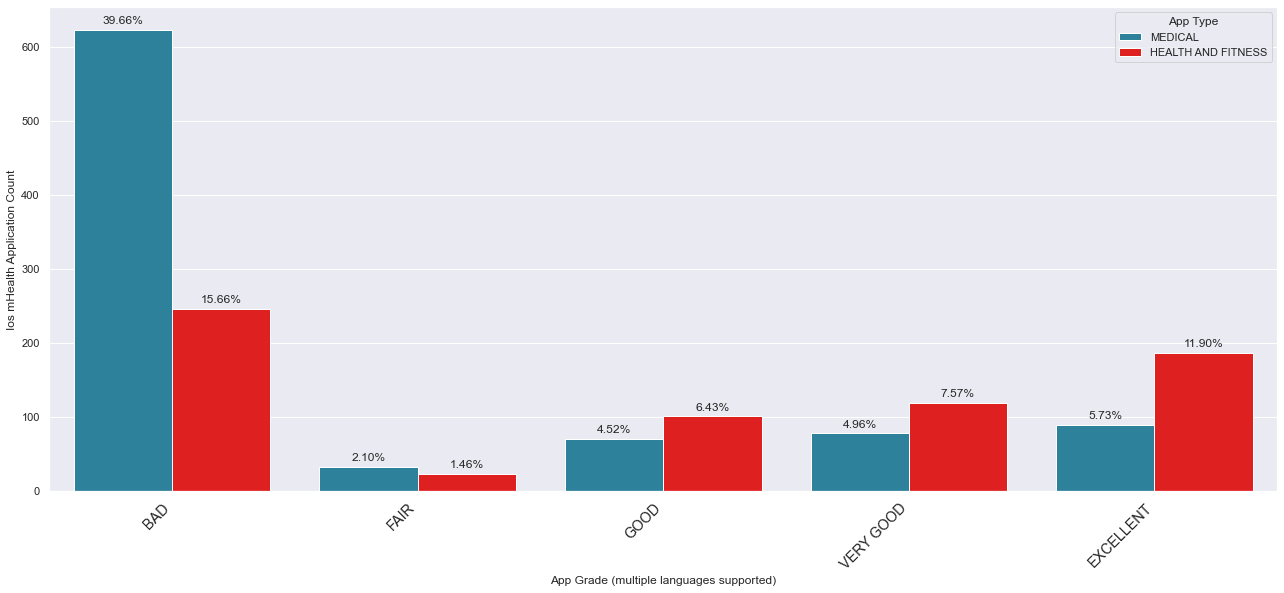

In [47]:
draw_count_plot_with_annot(df, 'App Grade', 'App Grade (multiple languages supported)',
                           'Ios mHealth Application Count',hue= 'App Type', fig_size=(18,6), 
                           
     order=app_grade_order, annotCount=False, palette=['#1C8BAD', 'red'])

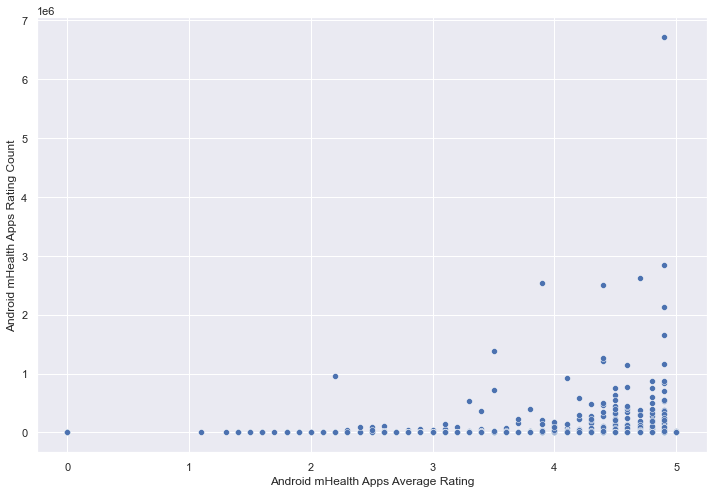

In [48]:
sbn.scatterplot(data=df, y='Rating Count', x='Average Rating')
fig = pyplot.gcf()
fig.set_size_inches(12, 8)
pyplot.xlabel('Android mHealth Apps Average Rating')
pyplot.ylabel('Android mHealth Apps Rating Count')
pyplot.show()

#### ASSOCIATION RULE MINING

In [49]:
def convert_consequent_to_str(consq):
    return str(consq).replace("frozenset({'", '').replace("})", '').replace("'", '')

def convert_antecedent_to_str(antecedent):
    antecedent = str(antecedent).replace("frozenset({'", '').replace("})", '').replace("'", '')
    return antecedent

def prepare_apriori_columns(df, column_list):
    apriori_df = list()
    for col in column_list:
        apriori_df.append(pd.get_dummies(df[col], prefix=col))
    apriori_df = pd.concat(apriori_df, axis=1)
    return apriori_df

def get_conditions_which_apps_are_most_likely_rated(min_support, min_threshold):
    apriori_df = prepare_apriori_columns(df,['Age Rating', 'InApp Purchase', 'Downloads',
                                                       'App Grade', 'is_app_ever_updated', 
                        'Download Type', 'is_available_in_multiple_countries', 'Rating Count Range',
                                             'is_updated_this_year', 'Price Category'] )
    rules = apriori(apriori_df, min_support=min_support, use_colnames=True)
    association_rules_df = association_rules(rules, metric='confidence', min_threshold=min_threshold)
    association_rules_df["antecedent_len"] = association_rules_df["antecedents"].apply(lambda x: len(x))
    association_rules_df["consequents_len"] = association_rules_df["consequents"].apply(lambda x: len(x))
    association_rules_df['antecedents'] = association_rules_df['antecedents'].apply(convert_antecedent_to_str)
    association_rules_df['consequents'] = association_rules_df['consequents'].apply(convert_consequent_to_str)
    association_rules_df.sort_values(by=['confidence'], ascending=False, inplace=True)
    return association_rules_df[(association_rules_df['consequents_len']==1) & 
                                (association_rules_df['antecedent_len']>1)]

In [50]:
def print_consequents_and_antecedents(df, consequent):
    filtered_df = df[df['consequents'].str.find(consequent) > -1]
    i = 1
    for index in filtered_df.index:
        if (i < 10):
            ants = filtered_df.at[index, 'antecedents']
            cons = filtered_df.at[index, 'consequents']
            support = filtered_df.at[index, 'support']
            conviction = filtered_df.at[index, 'conviction']
            confidence = filtered_df.at[index, 'confidence']
            print(f'{i}. {ants} => {cons} ({round(support,2), round(confidence,2), round(conviction,2)})')
            i = i + 1

In [51]:
association_df = get_conditions_which_apps_are_most_likely_rated(0.5, 0.5)

In [52]:
print_consequents_and_antecedents(association_df,'Download Type')

1. is_app_ever_updated_True, Price Category_0, Age Rating_PEGI 3, is_updated_this_year_True => Download Type_FREE ((0.63, 1.0, inf))
2. Price Category_0, Age Rating_PEGI 3, is_available_in_multiple_countries_False => Download Type_FREE ((0.56, 1.0, inf))
3. Price Category_0, Age Rating_PEGI 3 => Download Type_FREE ((0.81, 1.0, inf))
4. Price Category_0, Age Rating_PEGI 3, is_updated_this_year_True => Download Type_FREE ((0.63, 1.0, inf))
5. is_app_ever_updated_True, Price Category_0, is_available_in_multiple_countries_False => Download Type_FREE ((0.56, 1.0, inf))
6. is_app_ever_updated_True, Price Category_0, is_updated_this_year_True => Download Type_FREE ((0.65, 1.0, inf))
7. is_app_ever_updated_True, Price Category_0, Age Rating_PEGI 3, is_available_in_multiple_countries_False => Download Type_FREE ((0.55, 1.0, inf))
8. Price Category_0, is_available_in_multiple_countries_False => Download Type_FREE ((0.57, 1.0, inf))
9. Price Category_0, is_updated_this_year_True => Download Type_

In [53]:
print_consequents_and_antecedents(association_df,'App Grade')

1. Rating Count Range_0, Age Rating_PEGI 3 => App Grade_BAD ((0.51, 1.0, inf))
2. is_app_ever_updated_True, Age Rating_PEGI 3 => App Grade_BAD ((0.52, 0.55, 0.99))


In [54]:
print_consequents_and_antecedents(association_df,'Age Rating')

1. Rating Count Range_0, App Grade_BAD => Age Rating_PEGI 3 ((0.51, 0.98, 1.82))
2. is_app_ever_updated_True, App Grade_BAD => Age Rating_PEGI 3 ((0.52, 0.98, 1.71))
3. is_app_ever_updated_True, InApp Purchase_False => Age Rating_PEGI 3 ((0.57, 0.98, 1.68))
4. is_app_ever_updated_True, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.6, 0.97, 1.24))
5. Price Category_0, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.56, 0.97, 1.2))
6. Download Type_FREE, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.56, 0.97, 1.2))
7. Download Type_FREE, is_available_in_multiple_countries_False, Price Category_0 => Age Rating_PEGI 3 ((0.56, 0.97, 1.2))
8. is_app_ever_updated_True, Price Category_0, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.55, 0.97, 1.17))
9. is_app_ever_updated_True, Download Type_FREE, is_available_in_multiple_countries_False => Age Rating_PEGI 3 ((0.55, 0.97, 1.17))


In [55]:
print_consequents_and_antecedents(association_df,'is_updated_this_year')

1. is_app_ever_updated_True, Price Category_0, Age Rating_PEGI 3, Download Type_FREE => is_updated_this_year_True ((0.63, 0.79, 1.37))
2. is_app_ever_updated_True, Price Category_0, Age Rating_PEGI 3 => is_updated_this_year_True ((0.63, 0.79, 1.37))
3. is_app_ever_updated_True, Download Type_FREE, Age Rating_PEGI 3 => is_updated_this_year_True ((0.63, 0.79, 1.37))
4. is_app_ever_updated_True, Download Type_FREE, Price Category_0 => is_updated_this_year_True ((0.65, 0.79, 1.34))
5. is_app_ever_updated_True, Price Category_0 => is_updated_this_year_True ((0.65, 0.79, 1.34))
6. is_app_ever_updated_True, Download Type_FREE => is_updated_this_year_True ((0.65, 0.79, 1.34))
7. Download Type_FREE, Age Rating_PEGI 3 => is_updated_this_year_True ((0.63, 0.78, 1.27))
8. Price Category_0, Age Rating_PEGI 3 => is_updated_this_year_True ((0.63, 0.78, 1.27))
9. Download Type_FREE, Age Rating_PEGI 3, Price Category_0 => is_updated_this_year_True ((0.63, 0.78, 1.27))


In [56]:
print_consequents_and_antecedents(association_df,'Price Category')

1. is_app_ever_updated_True, Download Type_FREE, Age Rating_PEGI 3, is_updated_this_year_True => Price Category_0 ((0.63, 1.0, inf))
2. Download Type_FREE, Age Rating_PEGI 3, is_available_in_multiple_countries_False => Price Category_0 ((0.56, 1.0, inf))
3. Download Type_FREE, Age Rating_PEGI 3 => Price Category_0 ((0.81, 1.0, inf))
4. Download Type_FREE, Age Rating_PEGI 3, is_updated_this_year_True => Price Category_0 ((0.63, 1.0, inf))
5. is_app_ever_updated_True, Download Type_FREE, is_available_in_multiple_countries_False => Price Category_0 ((0.56, 1.0, inf))
6. is_app_ever_updated_True, Download Type_FREE, is_updated_this_year_True => Price Category_0 ((0.65, 1.0, inf))
7. is_app_ever_updated_True, Download Type_FREE, Age Rating_PEGI 3, is_available_in_multiple_countries_False => Price Category_0 ((0.55, 1.0, inf))
8. Download Type_FREE, is_available_in_multiple_countries_False => Price Category_0 ((0.57, 1.0, inf))
9. is_app_ever_updated_True, Download Type_FREE, Age Rating_PEGI

#### CLUSTERING

- Rating Count
- Country Count
- Price
- Average Rating

In [57]:
def draw_elbow_graph(kmeans_df):
    wcss=[]
    for i in range(1,15):
        kmeans = KMeans(i)
        kmeans.fit(kmeans_df)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,15)
    pyplot.subplot(2, 2, 1)
    pyplot.plot(number_clusters,wcss)
    pyplot.title('The Elbow title')
    pyplot.xlabel('Number of clusters')
    pyplot.ylabel('WCSS')
    fig = pyplot.gcf()
    fig.set_size_inches(24, 16)

In [58]:
def execute_kmeans(df, columns,n_cluster):
    standard_scaler = StandardScaler()
    kmeans_df = df[columns]
    kmeans_df_scaled = standard_scaler.fit_transform(kmeans_df)
    draw_elbow_graph(kmeans_df_scaled)
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(kmeans_df_scaled)
    labels = kmeans.predict(kmeans_df_scaled)
    centroids = kmeans.cluster_centers_
    kmeans_df_cluster = kmeans_df.copy()
    kmeans_df_cluster['cluster'] = labels
#     print(kmeans_df_cluster['cluster'].value_counts())
    if (len(columns) == 3):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    elif (len(columns) == 4):
        ax = pyplot.subplot(2, 2, 2, projection='3d')
        ax.scatter(kmeans_df_scaled[:,0], kmeans_df_scaled[:,1], kmeans_df_scaled[:,2] , kmeans_df_scaled[:,3]
                   ,c=kmeans.labels_, 
                   cmap='rainbow',
               edgecolor='k', s=40, alpha = 0.5)
        ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
               kmeans.cluster_centers_[:,2], kmeans.cluster_centers_[:,3], s = 300, c = 'r',
               marker='*', label = 'Centroid')
    else:
        ax = pyplot.subplot(2, 2, 2)
        ax.scatter(kmeans_df_scaled[:, 0],kmeans_df_scaled[:, 1],
            c=kmeans.labels_, cmap='rainbow')
    
    fig = pyplot.gcf()
    fig.set_size_inches(20, 16)
    return kmeans_df_cluster

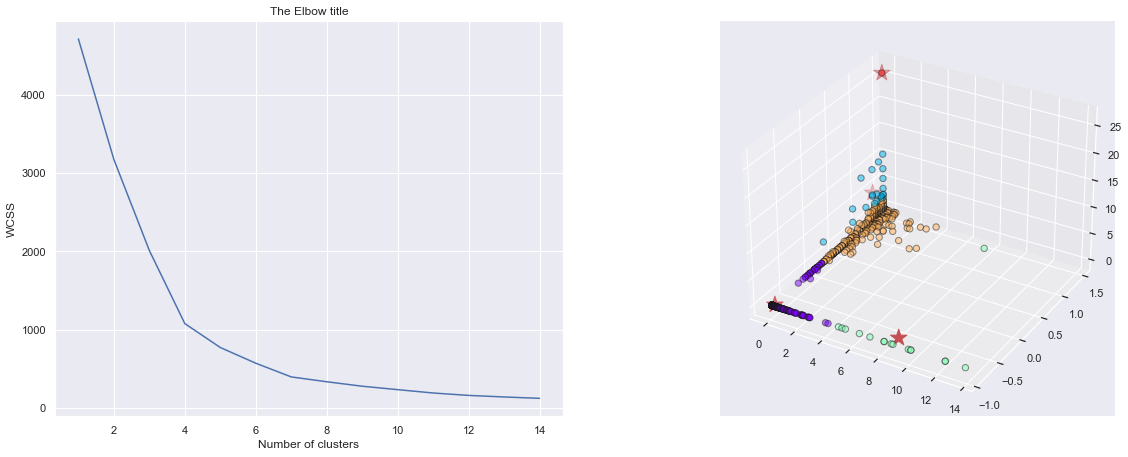

In [59]:
kmeans_df_cluster_df1 = execute_kmeans(df, ['Price', 'Average Rating', 'Rating Count'], 5)

In [60]:
kmeans_df_cluster_df1['cluster'].value_counts()

0    838
3    695
1     21
2     16
4      1
Name: cluster, dtype: int64

In [61]:
kmeans_df_cluster_df1.groupby(by='cluster').min()

,Price,Average Rating,Rating Count
cluster,,,
0,0.00,0.0,0
1,0.00,2.2,710000
2,38.99,0.0,0
3,0.00,2.2,5
4,0.00,4.9,6710000


In [62]:
kmeans_df_cluster_df1.groupby(by='cluster').max()

,Price,Average Rating,Rating Count
cluster,,,
0,32.99,2.1,7940
1,0.00,4.9,2840000
2,109.99,4.6,76
3,34.49,5.0,630000
4,0.00,4.9,6710000


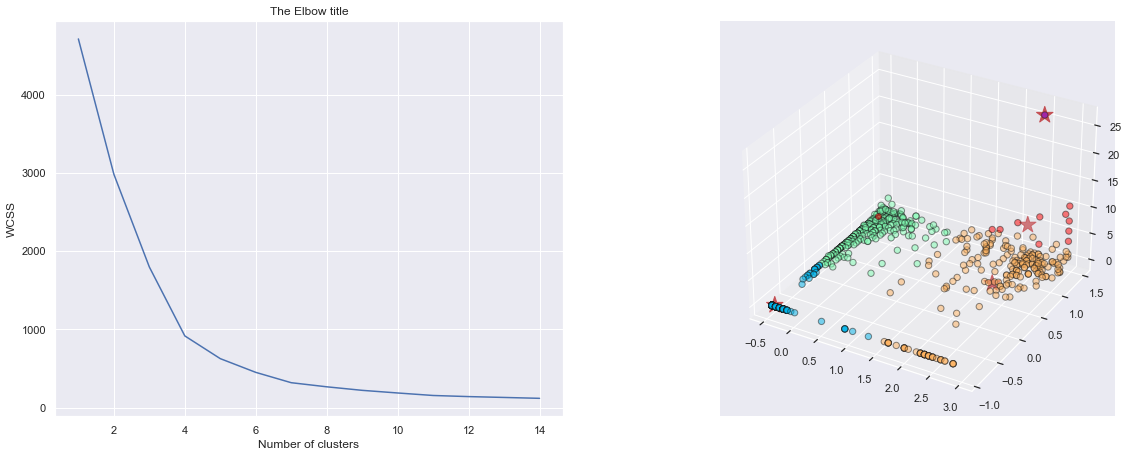

In [63]:
kmeans_df_cluster_df2 = execute_kmeans(df, ['Country Count', 'Average Rating', 'Rating Count'], 5)

In [64]:
kmeans_df_cluster_df2['cluster'].value_counts()

1    795
2    530
3    234
4     11
0      1
Name: cluster, dtype: int64

In [65]:
kmeans_df_cluster_df2.groupby(by='cluster').min()

,Country Count,Average Rating,Rating Count
cluster,,,
0,43,4.9,6710000
1,1,0.0,0
2,1,2.1,5
3,21,0.0,0
4,8,3.5,1140000


In [66]:
kmeans_df_cluster_df2.groupby(by='cluster').max()

,Country Count,Average Rating,Rating Count
cluster,,,
0,43,4.9,6710000
1,26,2.0,7940
2,21,5.0,867000
3,50,5.0,954000
4,50,4.9,2840000


#### CLASSIFICATION MODEL

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1571 non-null   int64  
 1   App Name                            1571 non-null   object 
 2   Age Rating                          1571 non-null   object 
 3   Price                               1571 non-null   float64
 4   InApp Purchase                      1571 non-null   bool   
 5   Average Rating                      1571 non-null   float64
 6   Rating Count                        1571 non-null   int64  
 7   App Link                            1571 non-null   object 
 8   Last Updated                        1571 non-null   object 
 9   Released Date                       1317 non-null   object 
 10  Downloads                           1571 non-null   object 
 11  Version                             1570 no

##### Rating count is a good variable to determine the average rating based on correlation

In [68]:
def create_ordinal_fields(df):
    age_rating_map = {'PEGI 3' : 0, 'PEGI 12' : 1 , 'PEGI 18' : 2, 'PEGI 16' : 3, 'None': 4 }
    app_grading_map = {'EXCELLENT' : 4, 'VERY GOOD' : 3, 'GOOD' : 2, 'FAIR' : 1, 'BAD' : 0 }
    rating_count_map = {'0' : 0, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6, '1,000+' : 7,
                       '5,000+' : 8, '10,000+' : 9, '50,000+' : 10, '100,000+' : 11, '500,000+' : 12, '1,000,000+': 13,
                       '5,000,000+' : 14, '10,000,000+' : 15, '50,000,000+' : 16, '100,000,000+' : 17,
                        '500,000,000+' : 18, '1,000,000,000+' : 19}
    download_count_map = {'0' : 0, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6, '1,000+' : 7,
                       '5,000+' : 8, '10,000+' : 9, '50,000+' : 10, '100,000+' : 11, '500,000+' : 12, '1,000,000+': 13,
                          '5,000,000+' : 14, '10,000,000+' : 15, '50,000,000+' : 16, '100,000,000+' : 17, 
                         '500,000,000+' : 18, '1,000,000,000+' : 19}
    price_map = {np.nan : 0, 'None' : 0, '0+' : 1, '1+' : 1, '5+' : 2, '10+' : 3, '50+' : 4, '100+' : 5, '500+' : 6}
    inapp_purchase_map = {True : 1, False : 0}
    service_type_map = {'PAID' : 1, 'FREE' : 0}
    app_type_map = {'MEDICAL' : 1, 'HEALTH AND FITNESS' : 0}
    english_supported_map = {True : 1, False : 0}
    available_in_multiple_countries = {True : 1, False : 0}
    version_app_dependent_map = {True : 1, False : 0}
    app_ever_updated_map = {True : 1, False : 0}
    updated_this_year_map = {True : 1, False : 0}
    df['Age Rating Ord'] = df['Age Rating'].replace(age_rating_map)
    df['InApp Purchase Ord'] = df['InApp Purchase'].replace(inapp_purchase_map)
#     df['is_english_supported Ord'] = df['InApp Purchase'].replace(english_supported_map)
    df['is_available_in_multiple_countries Ord'] = df['is_available_in_multiple_countries'].replace(available_in_multiple_countries)
    df['is_version_app_dependent Ord'] = df['is_version_app_dependent'].replace(version_app_dependent_map)
    df['is_app_ever_updated Ord'] = df['is_app_ever_updated'].replace(app_ever_updated_map)
    df['is_updated_this_year Ord'] = df['is_updated_this_year'].replace(updated_this_year_map)
    df['App Grade Ord'] = df['App Grade'].replace(app_grading_map)
    df['Download Type Ord'] = df['Download Type'].replace(service_type_map)
    df['Rating Count Range Ord'] = df['Rating Count Range'].replace(rating_count_map)
    df['App Type Ord'] = df['App Type'].replace(app_type_map)
    df['Price Category Ord'] = df['Price Category'].replace(price_map)
    df['Downloads Ord'] = df['Downloads'].replace(download_count_map)
    return df


In [69]:
updated_df = create_ordinal_fields(df.copy())

In [70]:
def draw_heatmap(df):
    df_num = df[['Price Category Ord', 'Downloads Ord','is_updated_this_year Ord', 
                 'is_available_in_multiple_countries Ord', 'InApp Purchase Ord', 'is_app_ever_updated Ord', 
                 'is_version_app_dependent Ord','Download Type Ord','Rating Count Range Ord', 'App Type Ord', 
                 'Age Rating Ord','App Grade Ord']]
    ax = sbn.heatmap( df_num.corr(method='spearman'), cmap = 'rainbow', annot=True)
    fig = pyplot.gcf()
    fig.set_size_inches(18, 8)
    font = {'family': 'Times New Roman','color':  'black','weight': 'bold','size': 16}
    pyplot.xlabel('Correlation map for Android dataset features', fontdict=font)

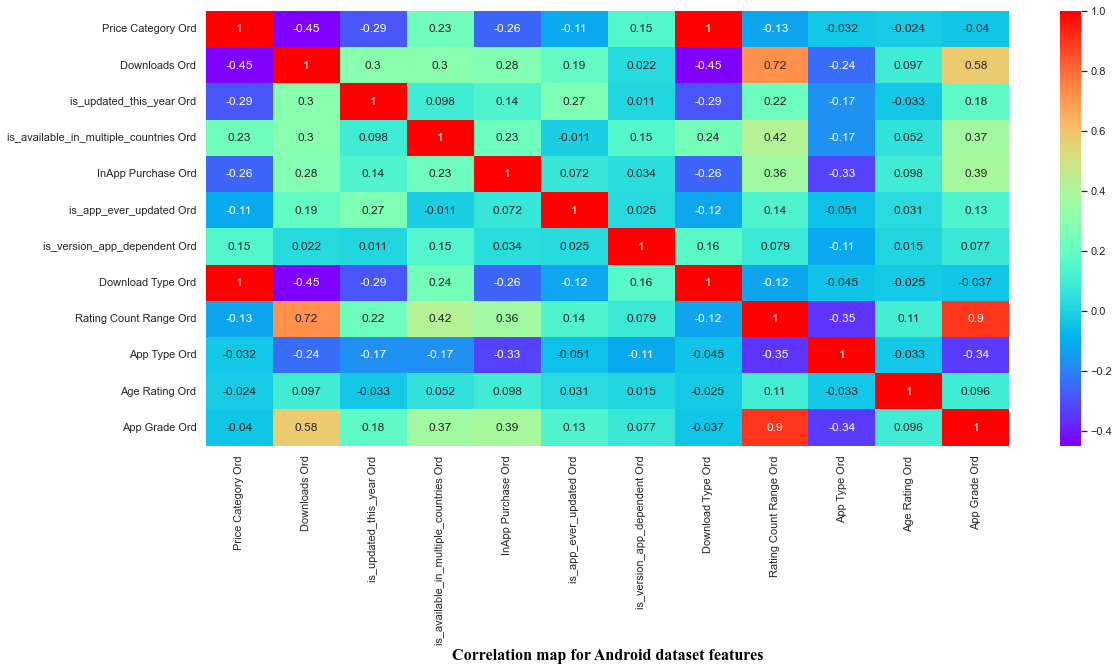

In [71]:
draw_heatmap(updated_df)

In [72]:
def get_top_features(no_of_features, X, Y):
    selector = SelectKBest(chi2, k="all") 
    selector.fit(X[target_attributes], Y)
    scores = (selector.scores_)
    argument_sort = list(np.argsort(scores))
    selected_attributes, selected_attribute_scores = [], []
    for i in range(len(target_attributes)-no_of_features,len(target_attributes)):
        value = argument_sort[i]
        selected_attributes.append(target_attributes[value])
        selected_attribute_scores.append(scores[value])
    return selected_attributes, selected_attribute_scores

In [73]:
target_attributes = ['Price Category Ord', 'Rating Count Range Ord', 'Downloads Ord', 'Age Rating Ord',
                     'InApp Purchase Ord', 'is_available_in_multiple_countries Ord', 'Download Type Ord',
                     'App Type Ord', 'is_version_app_dependent Ord', 'is_app_ever_updated Ord',
                     'is_updated_this_year Ord' ]

In [74]:
selected_attributes, selected_attributes_score = get_top_features(7, 
                                            updated_df, 
                                             updated_df['App Grade Ord'])

In [75]:
selected_attributes_score

[21.123366553513694,
 58.5693397776275,
 80.10541044015282,
 136.65017835316348,
 149.1295605412093,
 370.41820810996825,
 6168.013261637572]

In [76]:
selected_attributes

['is_version_app_dependent Ord',
 'Age Rating Ord',
 'App Type Ord',
 'is_available_in_multiple_countries Ord',
 'InApp Purchase Ord',
 'Downloads Ord',
 'Rating Count Range Ord']

Text(0.5, 0, 'SelectKBest for top 7 features (Android)')

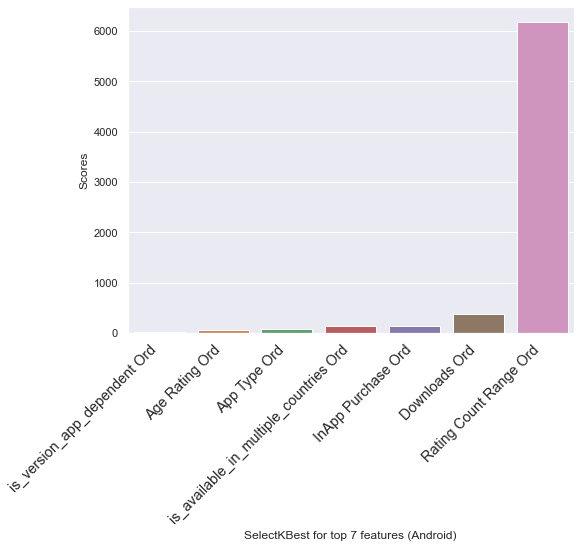

In [77]:
sbn.barplot(x=selected_attributes, y=selected_attributes_score)
set_plot_labels('Attributes', 'Scores', 'large')
fig = pyplot.gcf()
fig.set_size_inches(8, 6)
pyplot.xlabel('SelectKBest for top 7 features (Android)')

In [78]:
filtered_attributes = ['Rating Count Range Ord', 'Downloads Ord', 'InApp Purchase Ord',
                       'is_available_in_multiple_countries Ord', 'App Type Ord']

In [79]:
updated_df['App Grade Ord'].value_counts()

0    869
4    277
3    197
2    172
1     56
Name: App Grade Ord, dtype: int64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(updated_df[filtered_attributes],
                                                    updated_df['App Grade Ord'], test_size=0.30, random_state=42)

In [81]:
y_train.value_counts()

0    599
4    192
2    135
3    129
1     44
Name: App Grade Ord, dtype: int64

In [82]:
def oversample_train_data(X_train, y_train):
    oversampler = SMOTE()
    oversampled_df_X, oversampled_df_Y = oversampler.fit_resample(X_train, y_train)
    return oversampled_df_X, oversampled_df_Y

In [83]:
oversampled_df_X, oversampled_df_Y = oversample_train_data(X_train, y_train)

In [84]:
oversampled_df_Y.value_counts()

0    599
4    599
3    599
1    599
2    599
Name: App Grade Ord, dtype: int64

In [85]:
def create_and_fit_model(X, Y):
    clf = DecisionTreeClassifier()
    fitted_model = clf.fit(X,Y)
    print('Training score => ', fitted_model.score(X, Y))
    return fitted_model

In [86]:
fitted_model = create_and_fit_model(oversampled_df_X[filtered_attributes], oversampled_df_Y)

Training score =>  0.7656093489148581


In [87]:
def compute_validation_accuracy_and_classification_report(test_X, test_Y):
    y_pred = fitted_model.predict(test_X)
    print('Validation accuracy => ', fitted_model.score(test_X, test_Y))
    target_names = ['BAD','FAIR','GOOD', 'VERY GOOD', 'EXCELLENT']
    print(classification_report(test_Y, y_pred, target_names=target_names))

In [88]:
compute_validation_accuracy_and_classification_report(X_test[filtered_attributes], y_test)

Validation accuracy =>  0.7457627118644068
              precision    recall  f1-score   support

         BAD       1.00      0.94      0.97       270
        FAIR       0.26      0.75      0.39        12
        GOOD       0.37      0.62      0.46        37
   VERY GOOD       0.45      0.21      0.28        68
   EXCELLENT       0.58      0.62      0.60        85

    accuracy                           0.75       472
   macro avg       0.53      0.63      0.54       472
weighted avg       0.78      0.75      0.75       472

